In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import math

# Functions

In [6]:
def one_hot_encoder(v):
    return np.eye(v.max()+1)[v]
def one_hot_decoder(v):
    return np.argmax(v,axis=1)
def softmax(v):
    expv=np.exp(v)
    if v.shape[0]>1:
        return expv/expv.sum(axis=1,keepdims=True)
    else:
        return expv/expv.sum(axis=1)
def class_cost(Y,P):
    return -(Y*np.log(P)).mean()
def accuracy(Y,P):
    return (Y==P).mean()
def rmse(Y,P):
    return np.sqrt(((P-Y)**2).mean())
def populate_W(X,T,net_structure):
    net_structure=[X[0].size]+net_structure+[T[0].size]
    W=[]
    for i in range(len(net_structure)-1):
        W.append(np.random.randn(net_structure[i]+1,net_structure[i+1]))
    return W
def process(X,W):
    X=np.append(X,np.ones((X.shape[0],1)),1)
    return X.dot(W)
def sigmoid(v):
    return 1/(1+np.exp(-v))
def forward(X,W,f_transfer=sigmoid,f_output=sigmoid):
    v=[X]
    for l in range(len(W)-1):
        v.append(f_transfer(process(v[-1],W[l])))
    v.append(f_output(process(v[-1],W[-1])))
    return v
def derivate(layer,delta,W):
    next_delta=delta.dot(W[:-1,:].T)*layer*(1-layer)
    layer=np.append(layer,np.ones((layer.shape[0],1)),1)
    return layer.T.dot(delta),next_delta
def train(X,Y,net_structure,W_0=None,
          f_encode_Y=one_hot_encoder,
          f_decode_Y=one_hot_decoder,
          f_transfer=sigmoid,
          f_output=lambda v: softmax(sigmoid(v)),
          f_cost=class_cost,
          f_accuracy=accuracy,
          frac_test=0.2,random_state=None,
          learning_rate=10e-7,regularization=0,num_rounds=100000,
          report_step=100,print_every=5000,print_acc=True,plot_cost=True):
    reports=[]
    X,Y=sklearn.utils.shuffle(X,Y,random_state=random_state)
    num_test=int(frac_test*X.shape[0])
    X_train,Y_train=X[:-num_test],Y[:-num_test]
    X_test,Y_test=X[-num_test:],Y[-num_test:]
    T_train,T_test=f_encode_Y(Y_train),f_encode_Y(Y_test)
    if W_0!=None:
        W=W_0
    else:
        W=populate_W(X_train,T_train,net_structure)
    for n in range(num_rounds):
        preds_train,preds_test=forward(X_train,W,f_transfer,f_output),forward(X_test,W,f_transfer,f_output)
        if n % report_step==0:
            cost_train,cost_test=f_cost(T_train,preds_train[-1]),f_cost(T_test,preds_test[-1])
            if print_every and n % print_every==0:
                print("{:5d} {:0.5f} {:0.5f}".format(n,cost_train,cost_test))
            reports.append([n,cost_train,cost_test])
        delta=preds_train[-1]-T_train
        for l in reversed(range(len(W))):
            gradient,new_delta=derivate(preds_train[l],delta,W[l])
            delta=new_delta
            W[l]=W[l]*(1-learning_rate*regularization)-learning_rate*gradient
    cost_train,cost_test=f_cost(T_train,preds_train[-1]),f_cost(T_test,preds_test[-1])
    reports.append((num_rounds,cost_train,cost_test))
    Y_pred_train,Y_pred_test=f_decode_Y(preds_train[-1]),f_decode_Y(preds_test[-1])
    acc_train,acc_test=f_accuracy(Y_train,Y_pred_train),f_accuracy(Y_test,Y_pred_test)
    if print_acc:
        print('Train: {:0.2}, Test: {:0.2}'.format(acc_train,acc_test))
    if plot_cost:
        plt.plot([r[1] for r in reports])
        plt.plot([r[2] for r in reports])
        plt.show()
    return W,reports,(acc_train,acc_test)

# XOR gate

In [7]:
X_lst=[[0,0],[0,1],[1,0],[1,1]]*1000
Y_lst=[ 0,    1,    1,    0]   *1000
X_class=np.array(X_lst)
Y_class=np.array(Y_lst)

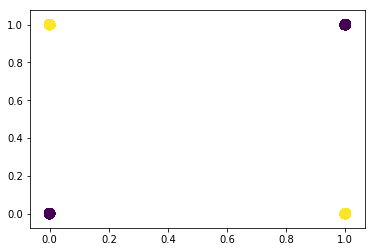

In [8]:
plt.scatter(X_class[:,0],X_class[:,1],c=Y_class,s=100,alpha=0.5)
plt.show()

## Modeling

    0 0.36948 0.37034
 1000 0.15893 0.15891
 2000 0.15663 0.15663
 3000 0.15663 0.15663
 4000 0.15663 0.15663
Train: 1.0, Test: 1.0


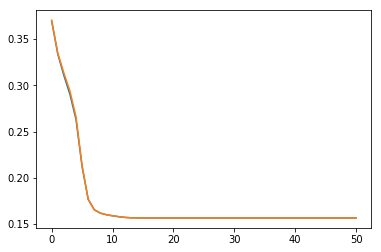

CPU times: user 7.64 s, sys: 152 ms, total: 7.79 s
Wall time: 7.63 s


In [9]:
%%time
W,report,accs=train(X_class,Y_class,net_structure=[4],
                    f_encode_Y=one_hot_encoder,
                    f_decode_Y=one_hot_decoder,
                    f_transfer=sigmoid,
                    f_output=lambda v: softmax(sigmoid(v)),
                    f_cost=class_cost,
                    f_accuracy=accuracy,
                    learning_rate=0.0001,regularization=0,
                    num_rounds=5000,print_every=1000)

# Donuts

In [10]:
num_donuts=2
num_per_donut=500
overlap=0.1
X_lst=[]
Y_lst=[]
for donut in range(num_donuts):
    r=np.random.uniform(size=num_per_donut)+(1-overlap)*donut+1
    d=2*math.pi*np.random.uniform(size=num_per_donut)
    X_lst.extend([[r[n]*math.cos(d[n]),r[n]*math.sin(d[n])] for n in range(num_per_donut)])
    Y_lst.extend([donut]*num_per_donut)
X_class=np.array(X_lst)
Y_class=np.array(Y_lst)

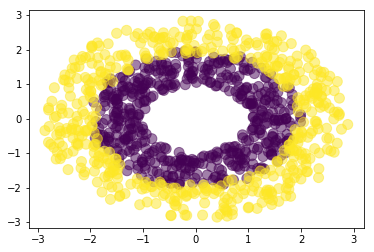

In [11]:
plt.scatter(X_class[:,0],X_class[:,1],c=Y_class,s=100,alpha=0.5)
plt.show()

## Modeling

    0 0.35294 0.35150
 1000 0.34182 0.34277
 2000 0.33558 0.33738
 3000 0.32358 0.32555
 4000 0.30563 0.30672
 5000 0.28548 0.28498
 6000 0.26657 0.26449
 7000 0.24944 0.24681
 8000 0.23464 0.23226
 9000 0.22305 0.22099
Train: 0.92, Test: 0.94


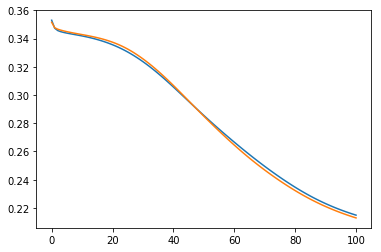

CPU times: user 6.67 s, sys: 164 ms, total: 6.84 s
Wall time: 6.65 s


In [12]:
%%time
W,report,accs=train(X_class,Y_class,net_structure=[8],
                    f_encode_Y=one_hot_encoder,
                    f_decode_Y=one_hot_decoder,
                    f_transfer=sigmoid,
                    f_output=lambda v: softmax(sigmoid(v)),
                    f_cost=class_cost,
                    f_accuracy=accuracy,
                    learning_rate=0.00005,regularization=0.1,
                    num_rounds=10000,print_every=1000)

# Donut chunks - balanced classes

In [149]:
num_donuts=2
num_chunks=2
num_per_chunk=500
overlap=0.1
X_lst=[]
Y_lst=[]
for donut in range(num_donuts):
    d_lims=sorted(list(np.random.uniform(size=num_chunks)))
    d_lims.append(d_lims[0]+1)
    for chunk in range(num_chunks):
        r=np.random.uniform(size=num_per_chunk)+(1-overlap)*donut+1
        d=2*math.pi*np.random.uniform(d_lims[chunk]  -overlap/(4*num_chunks)*(d_lims[chunk+1]-d_lims[chunk]),
                                      d_lims[chunk+1]+overlap/(4*num_chunks)*(d_lims[chunk+1]-d_lims[chunk]),
                                      size=num_per_chunk)
        X_lst.extend([[r[n]*math.cos(d[n]),r[n]*math.sin(d[n])] for n in range(num_per_chunk)])
        Y_lst.extend([donut*num_chunks+chunk]*num_per_chunk)
X_class=np.array(X_lst)
Y_class=np.array(Y_lst)

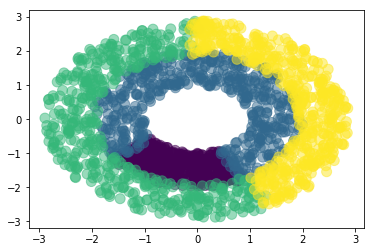

In [150]:
plt.scatter(X_class[:,0],X_class[:,1],c=Y_class,s=100,alpha=0.5)
plt.show()

## Modeling

    0 0.34611 0.34628
 5000 0.26597 0.26639
10000 0.26552 0.26655
15000 0.26662 0.26715
20000 0.26621 0.26722
25000 0.26586 0.26702
30000 0.26530 0.26583
35000 0.26531 0.26586
40000 0.26527 0.26611
45000 0.26510 0.26628
Train: 0.66, Test: 0.64


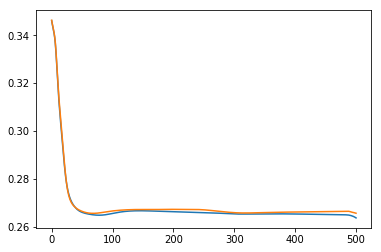

CPU times: user 1min 49s, sys: 256 ms, total: 1min 49s
Wall time: 1min 49s


In [151]:
%%time
W,report,accs=train(X_class,Y_class,net_structure=[8,8],
                    f_encode_Y=one_hot_encoder,
                    f_decode_Y=one_hot_decoder,
                    f_transfer=sigmoid,
                    f_output=lambda v: softmax(sigmoid(v)),
                    f_cost=class_cost,
                    f_accuracy=accuracy,
                    learning_rate=0.00001,regularization=0.15,
                    num_rounds=50000,print_every=5000)

# Donut chunks - imbalanced classes

In [137]:
num_donuts=2
num_chunks=2
avg_num_per_chunk=500
overlap=0.1
tot_num=num_donuts*num_chunks*avg_num_per_chunk
min_r=1
max_r=num_donuts+1
tot_area=math.pi*(max_r**2-min_r**2)
density=1.0*tot_num/tot_area
X_lst=[]
Y_lst=[]
for donut in range(num_donuts):
    min_donut_r=donut+1
    max_donut_r=donut+2
    donut_area=math.pi*(max_donut_r**2-min_donut_r**2)
    d_lims=sorted(list(np.random.uniform(size=num_chunks)))
    d_lims.append(d_lims[0]+1)
    for chunk in range(num_chunks):
        chunk_area=donut_area*(d_lims[chunk+1]-d_lims[chunk])
        num_in_chunk=int(density*chunk_area)
        r=np.random.uniform(size=num_in_chunk)+(1-overlap)*donut+1
        d=2*math.pi*np.random.uniform(d_lims[chunk]  -overlap/(2*num_chunks)*(d_lims[chunk+1]-d_lims[chunk]),
                                      d_lims[chunk+1]+overlap/(2*num_chunks)*(d_lims[chunk+1]-d_lims[chunk]),
                                      size=num_in_chunk)
        X_lst.extend([[r[n]*math.cos(d[n]),r[n]*math.sin(d[n])] for n in range(num_in_chunk)])
        Y_lst.extend([donut*num_chunks+chunk]*num_in_chunk)
X_class=np.array(X_lst)
Y_class=np.array(Y_lst)

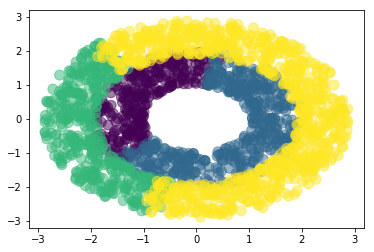

In [138]:
plt.scatter(X_class[:,0],X_class[:,1],c=Y_class,s=100,alpha=0.5)
plt.show()

## Modeling

    0 0.36521 0.36801
 5000 0.27244 0.26837
10000 0.27200 0.26809
15000 0.27953 0.27430
20000 0.26331 0.25668
25000 0.24841 0.24332
30000 0.24125 0.23478
35000 0.23891 0.23094
40000 0.23808 0.22937
45000 0.23779 0.22891
Train: 0.77, Test: 0.81


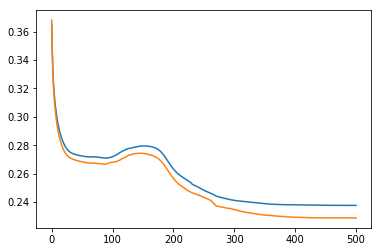

CPU times: user 1min 47s, sys: 144 ms, total: 1min 47s
Wall time: 1min 47s


In [144]:
%%time
W,report,accs=train(X_class,Y_class,net_structure=[8,8],
                    f_encode_Y=one_hot_encoder,
                    f_decode_Y=one_hot_decoder,
                    f_transfer=sigmoid,
                    f_output=lambda v: softmax(sigmoid(v)),
                    f_cost=class_cost,
                    f_accuracy=accuracy,
                    learning_rate=0.00001,regularization=0.15,
                    num_rounds=50000,print_every=5000)